<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Tutorial</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">24th April, 2019</span>
</div><h1>Tutorial:</h1><h1>Reservoir on DynapSE</h1>


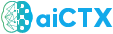

In [1]:
# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

In this tutorial we will try to implement a reservoir network on the DynapSE and train it to detect a specific pattern in the input signal.

<br>

## Task: Detect missing pulse

Our input consists of a sequence of equidistant pulses of some fixed width. However, every fourth pulse is omitted. The input can therefore be divided into periods consisting of three pulses and one longer gap each. 

In a slight modification of this, also the second pulse within a period is omitted. The task of the reservoir will be to detect this modification.

This task is inspired by the detection of anomalies in an ECG signal, which may consist of a missing peak. It is complex because the reservoir dynamics need to cover different time scales. On the one hand the pulses need to be detected. On the other hand, for each longer gap between pulses the reservoir needs to contain information whether this is after the third pulse within a period or after the first one, where there should be no gap. Therefore memory needs to last over a significant part of the input period, which is on a longer time scale than the individual pulses.

<br>

### Input to reservoir

To generate the input signal we can use the `SignalGen` class:

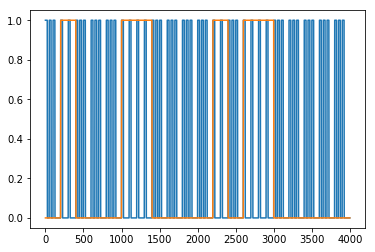

In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib inline  

import matplotlib
from matplotlib import pyplot as plt
%aimport tutorial
import numpy as np

signal_gen = tutorial.SignalGen(
    width_pulse=25,
    period=200,
    p_abnormal=0.2,
)

signal_training, tgt_training = signal_gen(100)
signal_test, tgt_test = signal_gen(20)


plt.plot(signal_test)
plt.plot(tgt_test)

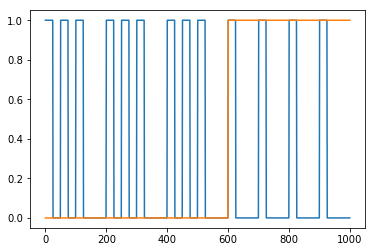

In [3]:
plt.plot(signal_test[400:1400])
plt.plot(tgt_test[400:1400])

### Encoding in spikes
We will use a delta-algorithm that emits spikes on channel 0 when the signal increases and on channel 1 when it decreases. For the type of signal we will be using, the function `signal_to_spikes` will do the job:

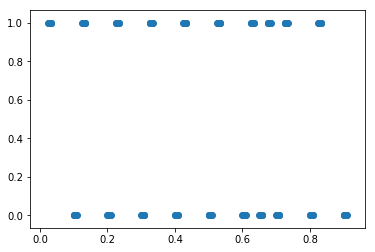

In [4]:
times_training, channels_training = tutorial.signal_to_spikes(
    signal_training, spikes_per_edge=10, ts_per_spike=1, dt=0.001
)
times_test, channels_test = tutorial.signal_to_spikes(
    signal_test, spikes_per_edge=10, ts_per_spike=1, dt=0.001
)

plt.scatter(times_training[:200], channels_training[:200])

## Network

### Architecture
We will split our reservoir into three neuron populations:
- Input, 64 neurons, to increase dimensionality of signal
- Recurrent exciratory, 256 neurons
- Inhibitory, 64 neurons
Each population will be implemented on a different core, so that we can tune biases individually. 

To implement this network on the chip and later also to send data and record activities, we will use the `DynapseControl` class, which provides a few useful methods.

Make sure you have cortexcontrol running with an open RPyC connection.

### Biases
The reservoir needs long memory but also should detect quick changes in the signal. This suggests a broad distribution of synaptic and neural time constants in the recurrent population. For the input we can have shorter time constants.
The file `biases.py` contains a set of biases that match these requirements. In general these biases should work independently of the individual chip but some fine tuning may be required.

In [5]:
from dynapse_control import DynapseControl, rectangular_neuron_arrangement

# - Parameters
# Neuron population sized
size_in = 64
size_rec = 256
size_inhib = 64
size_total = size_in + size_rec + size_inhib

# Arrangement of neurons on chip
firstid_in = 52
firstid_rec = 256
firstid_inhib = 529
width_in = 8
width_rec = 16
width_inhib = 8
# - IDs of neurons to be used
ids_in = rectangular_neuron_arrangement(firstid_in, size_in, width_in)
ids_rec = rectangular_neuron_arrangement(
    firstid_rec, size_rec, width_rec
)
ids_inhib = rectangular_neuron_arrangement(
    firstid_inhib, size_inhib, width_inhib
)
ids_all = np.array(ids_in + ids_rec + ids_inhib)

# Virtual neurons: one for each input channel (do not use neuron 0)
ids_virtual = np.array([1, 2])

# DynapseControl object (clear first 3 cores)
dc = DynapseControl(clearcores_list = range(3))
# Load biases and silence neurons that are still firing
dc.load_biases('biases.py')
dc.silence_hot_neurons(ids_all, 5)

dynapse_control: RPyC connection established through port 1300.
dynapse_control: CtxDynapse modules loaded.
dynapse_control: Initializing hardware.
dynapse_control: Hardware has already been initialized.
DynapseControl: Initializing DynapSE
DynapseControl: Spike generator module ready.
DynapseControl: Time constants of cores range(0, 16) have been reset.
DynapseControl: Neurons initialized.
	 4092 hardware neurons and 4092 virtual neurons available.
DynapseControl: Neuron connector initialized
DynapseControl: Connections to cores range(0, 3) have been cleared.
DynapseControl: FPGA spike generator prepared.
DynapseControl ready.
DynapseControl: Biases have been loaded from biases.py.
DynapseControl: Collecting IDs of neurons that spike within the next 5 seconds
DynapseControl: Generated new buffered event filter.
DynapseControl: 5 neurons spiked: [302, 303, 400, 420, 453]
DynapseControl: Neurons [302, 303, 400, 420, 453] will be silenced
DynapseControl: 5 neurons have been silenced.


[302, 303, 400, 420, 453]

If you need to tune biases manually, `DynapseControl` provides a few useful methods, such as `measure_firing_rates`, `monitor_firing_rates` and `sweep_freq_measure_rate`.

<br>

### Connections

For setting synaptic connections we need to keep in mind that for each neuron fan in is limited to 64. 

<br>

#### External (virutal) to input neurons
Each input neuron will have a randomly chosen, even number of input connecitons between 2 and 64. Half of those connect to input channel 0 the other half to input channel 1, with opposite sign. Signs are chosen randomly:

In [6]:
# - Generate input weight matrix
nums_connections = np.random.randint(1, 33, size=(1, size_in))
# Randomly flip sign
weights_0 = nums_connections * np.random.choice(
    (-1, 1), size=size_in
)
weights_in = np.zeros((2, size_in))
weights_in[0, :] = weights_0
weights_in[1, :] = -1 * weights_0  # Flip sign for channel 1

# Set connections in cortexcontrol
dc.set_virtual_connections_from_weights(
    weights=weights_in,
    virtualneuron_ids=ids_virtual,
    hwneuron_ids=ids_all,
    syn_exc=dc.syn_exc_fast,
    syn_inh=dc.syn_inh_fast,
    apply_diff=False,
)

DynapseControl: Excitatory connections of type `FAST_EXC` from virtual neurons to hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` from virtual neurons to hardware neurons have been set.


#### Connections to recurrent
Each neuron of the recurrent population receives input from 16 randomly chosen input neurons, 16 inhibitory neurons and 32 other excitatory neurons.

<br>

#### Connections to inhibitory
Each inhibitory neuron has presynaptic connections to 64 randomly chosen excitatory neurons.

For more flexibility in tuning parameters, the connections from input to recurrent groups have a different synapse type than the rest.

In [7]:
# - Weight matrix from input to recurrent
weights_in_rec = np.zeros((size_in, size_rec))
for col in weights_in_rec.T:
    input_choice = np.random.choice(size_in, size=16, replace=True)
    for row in input_choice:
        col[row] += 1

# - Weight matrix recurrent
weights_rec = np.zeros((size_rec, size_rec))
for col in weights_rec.T:
    input_choice = np.random.choice(size_rec, size=32, replace=True)
    for row in input_choice:
        col[row] += 1

# - Weight matrix recurrent to inhibitory
weights_rec_inhib = np.zeros((size_rec, size_inhib))
for col in weights_rec_inhib.T:
    input_choice = np.random.choice(size_rec, size=64, replace=True)
    for row in input_choice:
        col[row] += 1

# - Weight matrix inhibitory to recurrent
weights_inhib_rec = np.zeros((size_inhib, size_rec))
for col in weights_inhib_rec.T:
    input_choice = np.random.choice(size_inhib, size=16, replace=True)
    for row in input_choice:
        col[row] -= 1

# - Put matrices together
# Input weights (separate matrix to choose different synapse type)
weights_input = np.zeros((size_total, size_total))
weights_input[:size_in, size_in:size_in+size_rec] = weights_in_rec\
# Remaining weights
weights = np.zeros((size_total, size_total))
weights[size_in:size_in+size_rec, size_in:size_in+size_rec] = weights_rec
weights[-size_inhib:, size_in:size_in+size_rec] = weights_inhib_rec
weights[size_in:size_in+size_rec, -size_inhib:] = weights_rec_inhib

# - Set connections in cortexcontrol
# From input neurons
dc.set_connections_from_weights(
    weights=weights_input,
    hwneuron_ids=ids_all,
    syn_exc=dc.syn_exc_fast,
    syn_inh=dc.syn_inh_fast,
    apply_diff=False,
)

# From other neurons
dc.set_connections_from_weights(
    weights=weights,
    hwneuron_ids=ids_all,
    syn_exc=dc.syn_exc_slow,
    syn_inh=dc.syn_inh_fast,
    apply_diff=True,
)


DynapseControl: Excitatory connections of type `FAST_EXC` between hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` between hardware neurons have been set.
DynapseControl: Excitatory connections of type `SLOW_EXC` between hardware neurons have been set.
DynapseControl: Inhibitory connections of type `FAST_INH` between hardware neurons have been set.
DynapseControl: Connections have been written to the chip.


## Sending and recording data

You can only send 2**16-1 input spikes to the chip at once. Our training and test data are sufficiently small. In other cases it may be necessary to split the data into batches.
For sending an input and recording the neuron activities at the same time you can use the `send_arrays` method of the `DynapseControl` class.
To illustrate this, we will send the test set and record the resulting activities:

In [8]:
times_test_out, channels_test_out = dc.send_arrays(
    channels=channels_test.astype(int),
    times=times_test,
    t_record=times_test[-1] + 0.5, # Record until 0.5s after end of test data
    record_neur_ids=ids_all, # IDs of neurons that should be recorded
    targetchip_id=0,
    targetcore_mask=15,
    record=True,
)

DynapseControl: Generating FPGA event list from arrays.
DynapseControl: Stimulus prepared from arrays.
DynapseControl: Stimulus preloaded.
DynapseControl: Updated existing buffered event filter.
DynapseControl: Starting stimulation for 4.434 s.
DynapseControl: Stimulation ended.
	Recorded 40467 event(s) and 1 trigger event(s)
		 Using trigger event 0
DynapseControl: Extracted event data


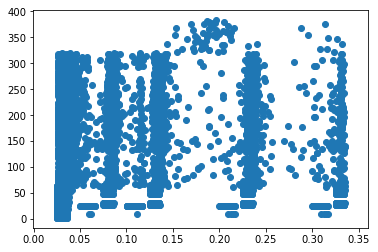

In [9]:
plt.scatter(times_test_out[:5000], channels_test_out[:5000])